In [39]:
import time
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import skimage.io
from keras.backend import clear_session
from time import time
import os
import tensorflow
print(tensorflow.__version__)
from numpy import asarray, expand_dims, squeeze, int32, fromstring, uint8, ceil
from tensorflow import Session, Graph, import_graph_def, gfile, GraphDef
from cv2 import cvtColor, rectangle, putText, namedWindow, setWindowProperty, imshow,imwrite, waitKey, \
COLOR_RGB2BGR, FONT_HERSHEY_SIMPLEX, WND_PROP_FULLSCREEN, IMREAD_COLOR, imdecode, resizeWindow, \
destroyAllWindows, VideoCapture, VideoWriter, VideoWriter_fourcc,resize, FILLED, getTextSize
import cv2 
import pickle
import copy
import numpy as np
import colorsys
from skimage.measure import find_contours
from matplotlib import patches,  lines
from matplotlib.patches import Polygon
import IPython.display


ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR) 
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.balloon import balloon
config = balloon.BalloonConfig()
BALLOON_DIR = os.path.join(ROOT_DIR, "datasets/balloon")



class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_NMS_THRESHOLD = 0.1

config = InferenceConfig()
config.display()

DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

TEST_MODE = "inference"


1.10.0

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_G

In [40]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


class seatbelt_class:

    def __init__(self, threshold):
        """
        This function initializes the class variables
        Arguments:
            ipaddress: This input is the IP address of gateway to send message
            port: This input is the port number of gateway to send message
            threshold: This input is the detection score threshold
        """
        #Bounding Box size to extend
        self.extend_ratio_w = 0.1
        self.extend_ratio_h = 0.1
        #Minimum threshold probability of a object to be detected
        self.score_threshold = threshold

        self.cnt = 0
        self.hand_list = {'0': '',  '1': 'fundus' } 

        self.frozen_graph = self.load_frozen_graph('/home/nupur/Desktop/Mask_RCNN-master/obj_detection/pb_11207/frozen_inference_graph.pb')

        self.image_tensor = self.frozen_graph.get_tensor_by_name('image_tensor:0')
        self.boxes = self.frozen_graph.get_tensor_by_name('detection_boxes:0')
        self.scores = self.frozen_graph.get_tensor_by_name('detection_scores:0')
        self.classes = self.frozen_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.frozen_graph.get_tensor_by_name('num_detections:0')
        self.sess = Session(graph=self.frozen_graph)
        self.Seatbelt_dict = { }

    def load_frozen_graph(self, model_path):
        '''
        Function to load the frozen protobuf file from the disk and parse it
        to retrieve the unserialized graph_def
        Arguments -
            model_path      : A string having the path of the tensorflow model(.pb).
        Returns -
            detection_graph : The unserialized graph_def that holds the network architecture.
        '''
        detection_graph = Graph()
        with detection_graph.as_default():
            od_graph_def = GraphDef()
            with gfile.GFile(model_path, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                import_graph_def(od_graph_def, name='')
        return detection_graph

    def seatbelt_detect(self, img ):
        """
        This function detects the object in the input frame
        Arguments:
            image_path: This input is the frame read from camera
        """
        # Read & convert jpeg image into numpy array
        font = FONT_HERSHEY_SIMPLEX
        font_scale = 1.0
        thickness = 1
        font_color = (0,0,0)

        image_input_tmp = cvtColor(img, COLOR_RGB2BGR) # convert RGB to BGR
        image_np = asarray(image_input_tmp) # convert to numpy array

        im_height, im_width = image_np.shape[:2]
        image_np_expanded = expand_dims(image_np, axis=0)

        box, scos, clas, det = self.sess.run([self.boxes, self.scores, self.classes, \
self.num_detections], feed_dict={self.image_tensor: image_np_expanded})

        scos = squeeze(scos)
        box = squeeze(box)
        clas = squeeze(clas).astype(int32)
        det = squeeze(det)
        #val = 1 if len(box) >=2 else len(box)
        for num in range(0, len(box), 1):
            if scos[num] > self.score_threshold:
                (xmin, ymin, xmax, ymax) = (box[num][1], box[num][0], box[num][3], \
box[num][2])
        #print (xmin, ymin, xmax, ymax)
                (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin \
* im_height, ymax * im_height)
        #print (left, right, top, bottom)
        

        #object_image = copy.deepcopy(img[int(top):int(bottom),int(left):int(right)])
                new_top = top-((bottom-top)*self.extend_ratio_h)
                new_bottom = bottom+((bottom-top)*self.extend_ratio_h)
                new_left = left-((right-left)*self.extend_ratio_w)
                new_right = right+((right-left)*self.extend_ratio_w)

                if new_top < 0:
                    new_top = 0
                if new_bottom > im_height:
                    new_bottom = im_height
                if new_left < 0:
                    new_left = 0
                if new_right > im_width:
                    new_right = im_width
       

                if str(clas[num]) == '1': 
                    rectangle(img, (int(new_left), int(new_top)), (int(new_right), \
    int(new_bottom)), (0, 255, 0), 3)
                    putText(img, self.hand_list[str(clas[num])], (int(left), int(top)), \
    FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                else:
                    rectangle(img, (int(new_left), int(new_top)), (int(new_right), \
    int(new_bottom)), (0, 0, 255), 3)
                    putText(img, self.hand_list[str(clas[num])], (int(left), int(top)), \
    FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                #imwrite(img, image_path)
        return left, right, top, bottom

In [57]:
if __name__ == '__main__':
    
    image_path = "/home/nupur/Downloads/Sample_1_High_Res.jpg"
    out_path = "//home/nupur/Desktop/Mask_RCNN-master/Source_codes/samples/balloon/img/"
    img = cv2.imread(image_path)
    OD = seatbelt_class(0.50)
    image1 = mpimg.imread(image_path)
    # plt.imshow(image1)
    # plt.axis("off")
    # plt.show()
    
    left, right, top, bottom = OD.seatbelt_detect(img )
    imwrite(out_path+"out.jpg",img)
    object_image = copy.deepcopy(img[int(top):int(bottom),int(left):int(right)])
    imwrite(out_path+"out1.jpg",object_image)
    image2 = mpimg.imread(out_path + "out1.jpg")
    # plt.imshow(image2)
    # plt.axis("off")
    # plt.show()
    img = cv2.imread(out_path + "out1.jpg", 1)
    #cv2.imshow("img",img) 

    #-----Converting image to LAB Color model----------------------------------- 
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    #cv2.imshow("lab",lab)

    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)
    #cv2.imshow('l_channel', l)
    #cv2.imshow('a_channel', a)
    #cv2.imshow('b_channel', b)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    #cv2.imshow('CLAHE output', cl)

    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))
    #cv2.imshow('limg', limg)

    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    cv2.imwrite(out_path + "test_img.jpg", final)
    height, width, channels = img.shape

In [58]:
R = height
C = width
  
# Find the number of covered side for mat[i][j]. 
def numofneighbour(mat, i, j): 
  
    count = 0; 
  
    # UP 
    if (i > 0 and mat[i - 1][j]): 
        count+= 1; 
  
    # LEFT 
    if (j > 0 and mat[i][j - 1]): 
        count+= 1; 
  
    # DOWN 
    if (i < R-1 and mat[i + 1][j]): 
        count+= 1
  
    # RIGHT 
    if (j < C-1 and mat[i][j + 1]): 
        count+= 1; 
  
    return count; 
  
# Returns sum of perimeter of shapes formed with 1s 
def findperimeter(mat): 
  
    perimeter = 0; 
  
    # Traversing the matrix and finding ones to 
    # calculate their contribution. 
    for i in range(0, R): 
        for j in range(0, C): 
            if (mat[i][j]): 
                perimeter += (4 - numofneighbour(mat, i, j)); 
  
    return perimeter; 
# Driver Code 
#mat = r['masks']
  
#print(findperimeter(mat), end="\n")

In [59]:
def display_images(images, titles=None, cols=4, cmap=None, norm=None,
                   interpolation=None):
    """Display the given set of images, optionally with titles.
    images: list or array of image tensors in HWC format.
    titles: optional. A list of titles to display with each image.
    cols: number of images per row
    cmap: Optional. Color map to use. For example, "Blues".
    norm: Optional. A Normalize instance to map values to colors.
    interpolation: Optional. Image interpolation to use for display.
    """
    titles = titles if titles is not None else [""] * len(images)
    rows = len(images) // cols + 1
    plt.figure(figsize=(14, 14 * rows // cols))
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.title(title, fontsize=9)
        plt.axis('off')
        plt.imshow(image.astype(np.uint8), cmap=cmap,
                   norm=norm, interpolation=interpolation)
        i += 1
    plt.show()


def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image


def display_instances(image,boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor=color, facecolor='none')
            ax.add_patch(p)
            x = x2 - x1
            y = y2 - y1
            
        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            x = random.randint(x1, (x1 + x2) // 2)
            caption = "{} {:.3f}".format(label, score) if score else label
        else:
            caption = captions[i]
        ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    #ax.imshow(masked_image.astype(np.uint8))
    #return masked_image.astype(np.uint8)
    if auto_show:
        plt.show()
    return x , y


In [60]:
dataset = balloon.BalloonDataset()
dataset.load_balloon(BALLOON_DIR, "val")

# Must call before using the dataset
dataset.prepare()

#print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))


MODEL_DIR= "/home/nupur/Desktop/Mask_RCNN-master/Source_codes/samples/model_ic/"


# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)



# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = "/home/nupur/Desktop/Mask_RCNN-master/Source_codes/samples/model_ic/inner_circle.h5"

# Load weights
#print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Processing 1 images
image                    shape: (880, 971, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/home/nupur/anaconda2/envs/MaskRCNN/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


372 552


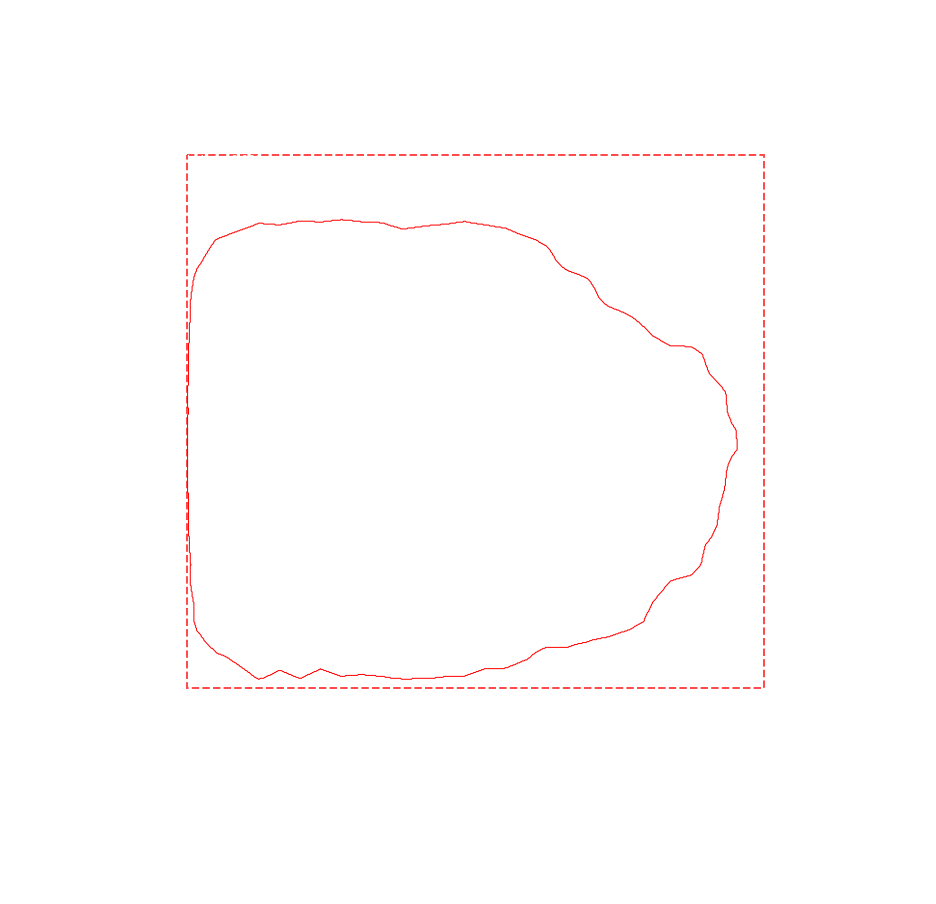

In [61]:
image = skimage.io.imread("/home/nupur/Desktop/Mask_RCNN-master/Source_codes/samples/balloon/img/test_img.jpg")

# Run detection
results = model.detect([image], verbose=1)
ax = get_ax(1)
r = results[0]
# Visualize results

#visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                            dataset.class_names, r['scores'], ax=ax)
(x , y )= display_instances(image, r['rois'], r['masks'], r['class_ids'],dataset.class_names, r['scores'], ax=ax)
#plt.savefig('/home/nupur/Desktop/Mask_RCNN-master/Source_codes/samples/balloon/img/test.jpg',bbox_inches='tight', pad_inches=-0.0005,orientation= 'landscape') 
#image3 = mpimg.imread("/home/nupur/Desktop/Mask_RCNN-master/Source_codes/samples/balloon/img/test.jpg")
#plt.close()
print (x,y)


In [62]:

mat = r['masks']
  
#print(findperimeter(mat), end="\n")
p = findperimeter(mat)
print ("perimeter of inner circle",p)
area_inner_circle = np.sum(r['masks'])
print ("perimeter=", p )

circularity = (p*p) / (4 * 3.14 * area_inner_circle)
c = 1/circularity

print ("----------------------------------------------")
print("circularity of inner circle ==>" , c)
print("------------------------------------------------")


perimeter of inner circle 2240
perimeter= 2240
----------------------------------------------
circularity of inner circle ==> 0.6015713329081633
------------------------------------------------


In [63]:
#finding inner radius
import cmath

def quadratic_eqn(a , b , c):
    d = (b**2) - (4*a*c)

    sol1 = (-b-cmath.sqrt(d))/(2*a)
    sol2 = (-b+cmath.sqrt(d))/(2*a)
    return sol1 , sol2

a = 19.71
b= -(np.square(p))
c= 2*np.square(area_inner_circle)
sol1 , sol2= quadratic_eqn(a , b , c)   
print (sol1 , sol2)

rad1 =np.sqrt(sol1.real)
rad2 = np.sqrt(sol2.real)
if y>x :
    vertical_radius_inn = max(rad1 , rad2)
    horizontal_radius_inn = min(rad1 , rad2)
else :
    vertical_radius_inn = min(rad1 , rad2)
    horizontal_radius_inn = max(rad1 , rad2)
    
print (horizontal_radius_inn, vertical_radius_inn)



(25593.991110690233+0j) (228977.29250168926+0j)
159.98122111888705 478.5157181344091


Processing 1 images
image                    shape: (880, 971, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/home/nupur/anaconda2/envs/MaskRCNN/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


perimeter of outer circle 3014


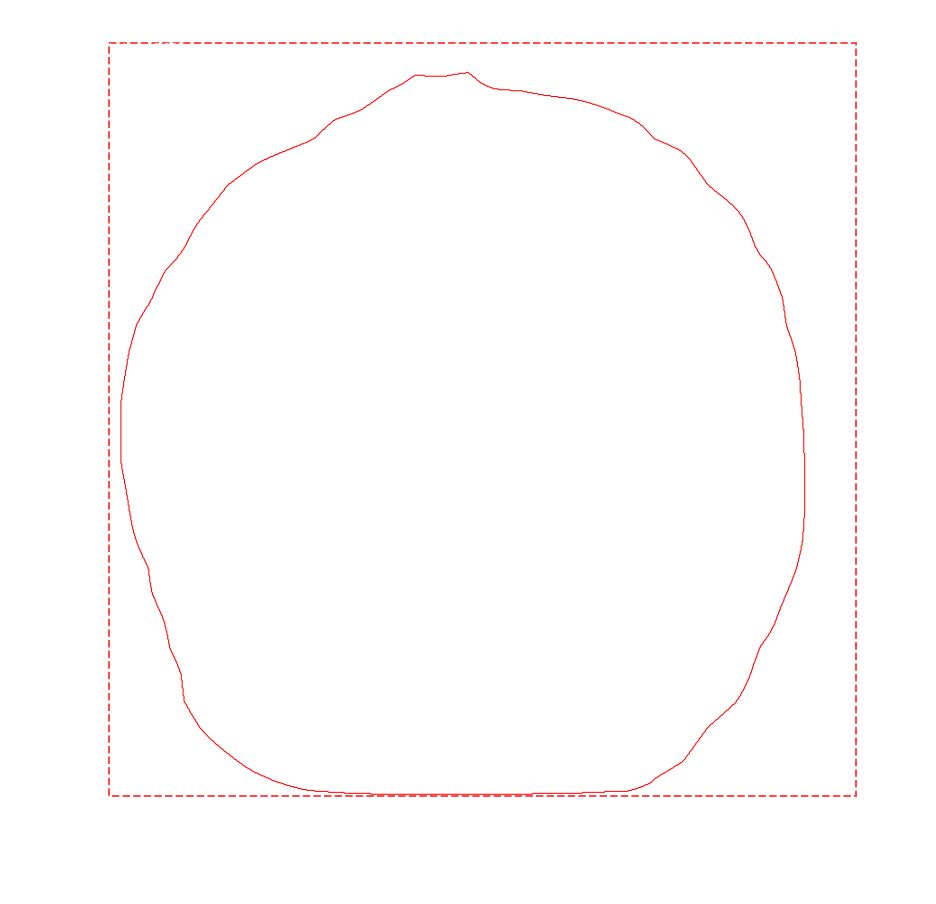

In [64]:
MODEL_DIR1 = '/home/nupur/Desktop/Mask_RCNN-master/Source_codes/logs/'


# In[25]:


with tf.device(DEVICE):
    model1 = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR1,
                              config=config)


# In[26]:


weights_path = "/home/nupur/Desktop/Mask_RCNN-master/Source_codes/samples/model_ic/outer_circle.h5"
# Load weights
#print("Loading weights ", weights_path)
model1.load_weights(weights_path, by_name=True)

#s7 = time.time()
#print("Loading_second_model", s7-s6)
# In[28]:


#image = skimage.io.imread("//home/nupur/Documents/Mask_RCNN-master/datasets/glaucoma/train/train/healthy_307.jpg")

# Run detection
results = model1.detect([image], verbose=1)
ax = get_ax(1)
r = results[0]
# Visualize results

#visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                            dataset.class_names, r['scores'], ax=ax)

x1 , y1 =display_instances(image, r['rois'], r['masks'], r['class_ids'],dataset.class_names, r['scores'], ax=ax)
mat = r['masks']
p1 = findperimeter(mat)
print ("perimeter of outer circle",p1)


In [65]:
plt.close()
image4 = mpimg.imread("/home/nupur/Desktop/Mask_RCNN-master/Source_codes/samples/balloon/img/test1.jpg")

area_outer_circle = np.sum(r['masks'])
mat = r['masks']
  
#print(findperimeter(mat), end="\n")
p1 = findperimeter(mat)
print ("perimeter of inner circle",p1)

temp = area_inner_circle/ area_outer_circle
CDR = np.sqrt(temp)
print ('-----------------------------------------------------------------------')
print ("CDR = " , CDR)
print ('-----------------------------------------------------------------------')
print (area_outer_circle)
print (area_inner_circle)
#end = time.time()

#print("time taken CDR" , end - s7)
#print("time taken to run the code" , end - ss)
'''
if (CDR < .47) :
	print(" congratulations , you are healthy")
if (CDR > .47 and CDR <.49) :
	print ("pre glaucoma")
if (CDR > .49 and CDR <.60) :
	print ("moderate glaucoma")
if (CDR >.60) :
	print ("quick.. consult a doc, you have Deep glaucoma")
'''


perimeter of inner circle 3014
-----------------------------------------------------------------------
CDR =  0.7225262574150871
-----------------------------------------------------------------------
460348
240322


'\nif (CDR < .47) :\n\tprint(" congratulations , you are healthy")\nif (CDR > .47 and CDR <.49) :\n\tprint ("pre glaucoma")\nif (CDR > .49 and CDR <.60) :\n\tprint ("moderate glaucoma")\nif (CDR >.60) :\n\tprint ("quick.. consult a doc, you have Deep glaucoma")\n'

In [66]:
#finding outer radius
import cmath

def quadratic_eqn(a , b , c):
    d = (b**2) - (4*a*c)

    sol1 = (-b-cmath.sqrt(d))/(2*a)
    sol2 = (-b+cmath.sqrt(d))/(2*a)
    return sol1 , sol2
a = 19.71
b= -(np.square(p1))
c= 2*np.square(area_outer_circle)
sol1 , sol2= quadratic_eqn(a , b , c)
print (sol1, sol2)

rad1 =np.sqrt(sol1.real)
rad2 = np.sqrt(sol2.real)
if y1>x1 :
    vertical_radius = max(rad1 , rad2)
    horizontal_radius = min(rad1 , rad2)
else :
    vertical_radius = min(rad1 , rad2)
    horizontal_radius = max(rad1 , rad2)
    
print (horizontal_radius, vertical_radius)


(52677.711345071424+0j) (408215.03345452267+0j)
229.5162550780912 638.9170786999849


In [67]:
vertical_CDR_ratio =(vertical_radius_inn/vertical_radius)
horizontal_CDR_ratio =(horizontal_radius_inn/horizontal_radius)
print("vertical_CDR_ratio=", vertical_CDR_ratio)
print("horizontal_CDR_ratio=",horizontal_CDR_ratio)




vertical_CDR_ratio= 0.7489480780636713
horizontal_CDR_ratio= 0.6970365609375014
